80th percentile of DM sends for closed-won/onboarded leads: 13


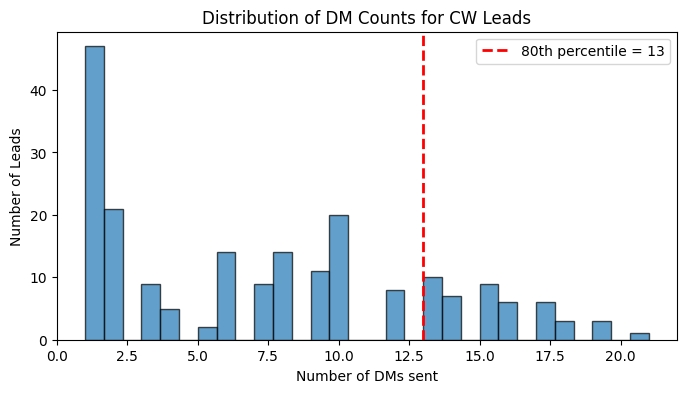

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load your leads summary (adjust path to wherever you saved it)
leads = pd.read_csv(
    "/Users/yukachen/marketing-operation/campaign_touch_points/data/Brizo __ Leads - data.csv",
    dtype={"brizo_id": str, "count": float},
    low_memory=False
)

# 2) Filter to only the CW group
cw = leads[ leads["stage"].str.lower().isin(["closed won", "onboarded"]) ]

# 3) Compute the 80th percentile of their DM counts
pct80 = cw["count"].quantile(0.8)
print(f"80th percentile of DM sends for closed-won/onboarded leads: {pct80:.0f}")

# 4) Plot the distribution and mark the 80th percentile
plt.figure(figsize=(8,4))
plt.hist(cw["count"], bins=30, alpha=0.7, edgecolor='black')
plt.axvline(pct80, color='red', linestyle='--', linewidth=2,
            label=f'80th percentile = {pct80:.0f}')
plt.title("Distribution of DM Counts for CW Leads")
plt.xlabel("Number of DMs sent")
plt.ylabel("Number of Leads")
plt.legend()
plt.show()

In [17]:
import pandas as pd
import janitor

leads = pd.read_csv('data/deduped_leads_long.csv').clean_names()
landing_date = pd.read_csv('data/brizo_list_landing_date.csv').clean_names()
brizo = pd.read_csv('data/combined.csv').clean_names()

In [18]:
selected_leads = leads[['lead_id','mobile_primary',
                        'business_phone_line_1','brizo_id', 
                        'created_date',
                        'first_mel_timestamp','latest_mql_timestamp',
                        'assigned_time_ae_',
                        'opportunity_created_date',
                        'closed_won_date',
                        'stage','unqualified_reason', 'closed_lost_reason']].drop_duplicates()

In [21]:
brizo_landing_date = brizo.merge(landing_date, on='list_source', how='left')

import re
import pandas as pd

def clean_to_10(s):
    # 1) remove any non-digits
    digits = re.sub(r'\D+', '', str(s))
    # 2) if >10 digits and starts with "1", drop the leading "1"
    if len(digits) > 10 and digits.startswith('1'):
        digits = digits[1:]
    # 3) only keep if exactly 10 digits
    return digits if len(digits) == 10 else None

for col in ['phone_number']:
    brizo_landing_date[col] = brizo_landing_date[col].apply(clean_to_10)

In [42]:
# ————————————————
# Prep: convert dates & clean phones
# ————————————————
date_cols = [
    'closed_won_date',
    'opportunity_created_date',
    'assigned_time_ae_',
    'latest_mql_timestamp',
    'first_mel_timestamp',
    'created_date'
]

# 1) parse your date columns once
for col in date_cols:
    selected_leads[col] = pd.to_datetime(
        selected_leads[col],
        errors='coerce'
    )

# 2) normalize phone strings
for col in ['mobile_primary', 'business_phone_line_1']:
    selected_leads[col] = (
        selected_leads[col]
          .astype(str)
          .str.replace(r'\D+', '', regex=True)
    )
    
match_brizo = selected_leads.merge(
    brizo_landing_date,
    on='brizo_id',
    how='inner'
).assign(match_key='brizo_id')


# ————————————————
# 2) Match by business_phone_line_1
# ————————————————
match_business = selected_leads.merge(
    brizo_landing_date,
    left_on='business_phone_line_1',
    right_on='phone_number',
    how='inner'
).assign(match_key='business_phone_line_1')


# ————————————————
# 3) Match by mobile_primary
# ————————————————
match_mobile = selected_leads.merge(
    brizo_landing_date,
    left_on='mobile_primary',
    right_on='phone_number',
    how='inner'
).assign(match_key='mobile_primary')


# ————————————————
# 4) Combine all matches into one DataFrame
# ————————————————
matched = pd.concat(
    [match_brizo, match_business, match_mobile],
    ignore_index=True
)


# ————————————————
# 5) Dedupe by brizo_id, keeping the most recent by your date‐priority
# ————————————————
# sort descending so “most recent” appears first for each brizo_id
matched = matched.sort_values(
    by=date_cols,
    ascending=False,
    na_position='last'
)

# 2) drop duplicates on BOTH brizo_id AND list_source
final_matched = (
    matched
      .drop_duplicates(
         subset=['brizo_id', 'list_source'],
         keep='first'
      )
      .reset_index(drop=True)
)


# ————————————————
# Inspect or save
# ————————————————
print(final_matched.head())




           lead_id mobile_primary business_phone_line_1          brizo_id  \
0  00Q8b00001xKLPF    70495715470           70482288300  d615ce74fd940a54   
1  00Q8b00001xKLPF    70495715470           70482288300  d615ce74fd940a54   
2  00Q8b00001xKLPF    70495715470           70482288300  d615ce74fd940a54   
3  00Q8b00001xKLPF    70495715470           70482288300  d615ce74fd940a54   
4  00Q8b00001xKLPF    70495715470           70482288300  d615ce74fd940a54   

  created_date first_mel_timestamp latest_mql_timestamp assigned_time_ae_  \
0   2022-10-31          2025-07-07           2025-07-07        2025-07-07   
1   2022-10-31          2025-07-07           2025-07-07        2025-07-07   
2   2022-10-31          2025-07-07           2025-07-07        2025-07-07   
3   2022-10-31          2025-07-07           2025-07-07        2025-07-07   
4   2022-10-31          2025-07-07           2025-07-07        2025-07-07   

  opportunity_created_date closed_won_date  ... unqualified_reason  \
0   

In [43]:
print(final_matched.columns)

Index(['lead_id', 'mobile_primary', 'business_phone_line_1', 'brizo_id',
       'created_date', 'first_mel_timestamp', 'latest_mql_timestamp',
       'assigned_time_ae_', 'opportunity_created_date', 'closed_won_date',
       'stage', 'unqualified_reason', 'closed_lost_reason', 'phone_number',
       'list_source', 'year_month', 'landing_start_date', 'landing_end_date',
       'match_key', 'brizo_id_x', 'brizo_id_y'],
      dtype='object')


In [44]:
# 1) List the columns you want to standardize
date_cols = [
    'landing_start_date',
    'landing_end_date',
    'created_date',
    'first_mel_timestamp',
    'latest_mql_timestamp',
    'assigned_time_ae_',
    'opportunity_created_date',
    'closed_won_date'
]

# 2) Loop through and normalize each to 'YYYY-MM-DD'
for col in date_cols:
    # a) Parse the diverse formats into Timestamps
    final_matched[col] = pd.to_datetime(final_matched[col], errors='coerce')
    # b) Convert to uniform 'YYYY-MM-DD' strings
    final_matched[col] = final_matched[col].dt.strftime('%Y-%m-%d')

# 3) Quick check
final_matched[date_cols].head()

,landing_start_date,landing_end_date,created_date,first_mel_timestamp,latest_mql_timestamp,assigned_time_ae_,opportunity_created_date,closed_won_date
0,2024-03-27,2024-04-09,2022-10-31,2025-07-07,2025-07-07,2025-07-07,2025-07-07,2025-07-07
1,2024-05-28,2024-06-10,2022-10-31,2025-07-07,2025-07-07,2025-07-07,2025-07-07,2025-07-07
2,2024-04-26,2024-05-09,2022-10-31,2025-07-07,2025-07-07,2025-07-07,2025-07-07,2025-07-07
3,2024-11-18,2024-11-14,2022-10-31,2025-07-07,2025-07-07,2025-07-07,2025-07-07,2025-07-07
4,2024-12-02,2024-12-04,2022-10-31,2025-07-07,2025-07-07,2025-07-07,2025-07-07,2025-07-07


In [ ]:
after_closed_won = final_matched[final_matched['closed_won_date'] > final_matched['landing_start_date']]

after_closed_won_id_phone = after_closed_won[['brizo_id', 'phone_number']]

after_closed_won_id_phone_counts = (
    after_closed_won_id_phone
      .groupby(['brizo_id', 'phone_number'])
      .size()
      .reset_index(name='count')
)
display(b4_closed_won_id_phone_counts)

,brizo_id,phone_number,count
0,02cf7f8f4f6d36f0,6417879988,6
1,05c988dd31b8a82d,7342540616,18
2,06297172ff7cfa89,3147718880,12
3,067e482f037261dc,6517743853,11
4,074d8604509fff21,3523691688,2
...,...,...,...
180,fc05c9cc577242cf,8132249888,2
181,fc211d11bfc3cc84,9897928888,18
182,fd74c5661bc90b04,7573668993,2
183,fd87102fe31eedcd,2106811593,2


In [46]:
check = final_matched[['brizo_id', 'phone_number', 'landing_start_date', 'closed_won_date']].drop_duplicates().dropna(subset=['closed_won_date'])
check.to_csv('data/check.csv', index=False)

In [ ]:
b4_closed_won = final_matched[final_matched['closed_won_date'] > final_matched['landing_start_date']]

b4_closed_won_id_phone = b4_closed_won[['brizo_id', 'phone_number']]

b4_closed_won_id_phone_counts = (
    b4_closed_won_id_phone
      .groupby(['brizo_id', 'phone_number'])
      .size()
      .reset_index(name='count')
)
display(b4_closed_won_id_phone_counts)
match_brizo = b4_closed_won_id_phone_counts.merge(
    final_matched,
    on='brizo_id',
    how='inner'
).assign(match_key='brizo_id')


# ————————————————
# 2) Match by business_phone_line_1
# ————————————————
match_business = b4_closed_won_id_phone_counts.merge(
    final_matched.drop(columns=['mobile_primary']),
    left_on='phone_number',
    right_on='business_phone_line_1',
    how='inner',
    suffixes=('', '_matched')
).assign(match_key='business_phone_line_1')




# ————————————————
# 3) Match by mobile_primary
# ————————————————
match_mobile = b4_closed_won_id_phone_counts.merge(
    final_matched,
    right_on='mobile_primary',
    left_on='phone_number',
    how='inner',
    suffixes=('', '_matched')
).assign(match_key='mobile_primary')


# ————————————————
# 4) Combine all matches into one DataFrame
# ————————————————
matched = pd.concat(
    [match_brizo, match_business, match_mobile],
    ignore_index=True
)


# ————————————————
# 5) Dedupe by brizo_id, keeping the most recent by your date‐priority
# ————————————————
# sort descending so “most recent” appears first for each brizo_id
matched = matched.sort_values(
    by=date_cols,
    ascending=False,
    na_position='last'
)

before_becoming_closed_won = matched.drop_duplicates(
    subset='brizo_id',
    keep='first'
).reset_index(drop=True)

before_becoming_closed_won.to_csv('data/before_becoming_closed_won.csv', index=False)

In [48]:
after_closed_won = final_matched[final_matched['closed_won_date'] < final_matched['landing_start_date']]

after_closed_won_id_phone = after_closed_won[['brizo_id', 'phone_number']]

after_closed_won_id_phone_counts = (
    after_closed_won_id_phone
      .groupby(['brizo_id', 'phone_number'])
      .size()
      .reset_index(name='count')
)
display(after_closed_won_id_phone_counts)
match_brizo = after_closed_won_id_phone_counts.merge(
    final_matched,
    on='brizo_id',
    how='inner'
).assign(match_key='brizo_id')


# ————————————————
# 2) Match by business_phone_line_1
# ————————————————
match_business = after_closed_won_id_phone_counts.merge(
    final_matched.drop(columns=['mobile_primary']),
    left_on='phone_number',
    right_on='business_phone_line_1',
    how='inner',
    suffixes=('', '_matched')
).assign(match_key='business_phone_line_1')




# ————————————————
# 3) Match by mobile_primary
# ————————————————
match_mobile = after_closed_won_id_phone_counts.merge(
    final_matched,
    right_on='mobile_primary',
    left_on='phone_number',
    how='inner',
    suffixes=('', '_matched')
).assign(match_key='mobile_primary')


# ————————————————
# 4) Combine all matches into one DataFrame
# ————————————————
matched = pd.concat(
    [match_brizo, match_business, match_mobile],
    ignore_index=True
)


# ————————————————
# 5) Dedupe by brizo_id, keeping the most recent by your date‐priority
# ————————————————
# sort descending so “most recent” appears first for each brizo_id
matched = matched.sort_values(
    by=date_cols,
    ascending=False,
    na_position='last'
)

after_becoming_closed_won = matched.drop_duplicates(
    subset='brizo_id',
    keep='first'
).reset_index(drop=True)

after_becoming_closed_won.to_csv('data/after_becoming_closed_won.csv', index=False)

,brizo_id,phone_number,count
0,01e43677fc2db22f,7542004968,1
1,020cc38031d71c90,8067716964,9
2,02cf7f8f4f6d36f0,6417879988,1
3,067e482f037261dc,6517743853,1
4,070456444fc36fd6,2183467941,1
...,...,...,...
124,ee5629904f00a389,3368521900,1
125,f07324f11020e38a,7705037338,1
126,f87723747cd7a4f4,9205680888,1
127,f8d8798d9aeb4875,5307627289,13


In [51]:
b4_sql = final_matched[final_matched['opportunity_created_date'] > final_matched['landing_start_date']]

b4_sql_id_phone = b4_sql[['brizo_id', 'phone_number']]

b4_sql_id_phone_counts = (
    b4_sql_id_phone
      .groupby(['brizo_id', 'phone_number'])
      .size()
      .reset_index(name='count')
)
display(b4_sql_id_phone_counts)
match_brizo = b4_sql_id_phone_counts.merge(
    final_matched,
    on='brizo_id',
    how='inner'
).assign(match_key='brizo_id')


# ————————————————
# 2) Match by business_phone_line_1
# ————————————————
match_business = b4_sql_id_phone_counts.merge(
    final_matched.drop(columns=['mobile_primary']),
    left_on='phone_number',
    right_on='business_phone_line_1',
    how='inner',
    suffixes=('', '_matched')
).assign(match_key='business_phone_line_1')




# ————————————————
# 3) Match by mobile_primary
# ————————————————
match_mobile = b4_sql_id_phone_counts.merge(
    final_matched,
    right_on='mobile_primary',
    left_on='phone_number',
    how='inner',
    suffixes=('', '_matched')
).assign(match_key='mobile_primary')


# ————————————————
# 4) Combine all matches into one DataFrame
# ————————————————
matched = pd.concat(
    [match_brizo, match_business, match_mobile],
    ignore_index=True
)


# ————————————————
# 5) Dedupe by brizo_id, keeping the most recent by your date‐priority
# ————————————————
# sort descending so “most recent” appears first for each brizo_id
matched = matched.sort_values(
    by=date_cols,
    ascending=False,
    na_position='last'
)

before_becoming_sql = matched.drop_duplicates(
    subset='brizo_id',
    keep='first'
).reset_index(drop=True)

before_becoming_sql.to_csv('data/before_becoming_sql.csv', index=False)

,brizo_id,phone_number,count
0,00370ffaea501b02,4106509949,13
1,003bf5ec93f0b157,7326571616,5
2,021c7944d16d125b,4135980033,10
3,025f27c28a153a88,7188663295,3
4,0265532a180cdbe7,8282943909,5
...,...,...,...
453,fc211d11bfc3cc84,9897928888,18
454,fd74c5661bc90b04,7573668993,2
455,fd87102fe31eedcd,2106811593,2
456,fdf175d8f3705583,9548852088,8


In [52]:
b4_mql = final_matched[final_matched['latest_mql_timestamp'] > final_matched['landing_start_date']]

b4_mql_id_phone = b4_mql[['brizo_id', 'phone_number']]

b4_mql_id_phone_counts = (
    b4_mql_id_phone
      .groupby(['brizo_id', 'phone_number'])
      .size()
      .reset_index(name='count')
)
display(b4_mql_id_phone_counts)
match_brizo = b4_mql_id_phone_counts.merge(
    final_matched,
    on='brizo_id',
    how='inner'
).assign(match_key='brizo_id')


# ————————————————
# 2) Match by business_phone_line_1
# ————————————————
match_business = b4_mql_id_phone_counts.merge(
    final_matched.drop(columns=['mobile_primary']),
    left_on='phone_number',
    right_on='business_phone_line_1',
    how='inner',
    suffixes=('', '_matched')
).assign(match_key='business_phone_line_1')




# ————————————————
# 3) Match by mobile_primary
# ————————————————
match_mobile = b4_mql_id_phone_counts.merge(
    final_matched,
    right_on='mobile_primary',
    left_on='phone_number',
    how='inner',
    suffixes=('', '_matched')
).assign(match_key='mobile_primary')


# ————————————————
# 4) Combine all matches into one DataFrame
# ————————————————
matched = pd.concat(
    [match_brizo, match_business, match_mobile],
    ignore_index=True
)


# ————————————————
# 5) Dedupe by brizo_id, keeping the most recent by your date‐priority
# ————————————————
# sort descending so “most recent” appears first for each brizo_id
matched = matched.sort_values(
    by=date_cols,
    ascending=False,
    na_position='last'
)

before_becoming_mql = matched.drop_duplicates(
    subset='brizo_id',
    keep='first'
).reset_index(drop=True)

before_becoming_mql.to_csv('data/before_becoming_mql.csv', index=False)

,brizo_id,phone_number,count
0,00370ffaea501b02,4106509949,13
1,003bf5ec93f0b157,7326571616,5
2,00bc3c5c2c1a3e46,2127249700,10
3,021c7944d16d125b,4135980033,10
4,025c0ab89b2b02c0,3193381038,6
...,...,...,...
717,fd87102fe31eedcd,2106811593,2
718,fdaffb81c97ad131,7175098488,14
719,fdce78e6f34e21cc,7812286427,13
720,fdf175d8f3705583,9548852088,8


In [53]:
b4_mel = final_matched[final_matched['first_mel_timestamp'] > final_matched['landing_start_date']]

b4_mel_id_phone = b4_mel[['brizo_id', 'phone_number']]

b4_mel_id_phone_counts = (
    b4_mel_id_phone
      .groupby(['brizo_id', 'phone_number'])
      .size()
      .reset_index(name='count')
)
display(b4_mel_id_phone_counts)
match_brizo = b4_mel_id_phone_counts.merge(
    final_matched,
    on='brizo_id',
    how='inner'
).assign(match_key='brizo_id')


# ————————————————
# 2) Match by business_phone_line_1
# ————————————————
match_business = b4_mel_id_phone_counts.merge(
    final_matched.drop(columns=['mobile_primary']),
    left_on='phone_number',
    right_on='business_phone_line_1',
    how='inner',
    suffixes=('', '_matched')
).assign(match_key='business_phone_line_1')




# ————————————————
# 3) Match by mobile_primary
# ————————————————
match_mobile = b4_mel_id_phone_counts.merge(
    final_matched,
    right_on='mobile_primary',
    left_on='phone_number',
    how='inner',
    suffixes=('', '_matched')
).assign(match_key='mobile_primary')


# ————————————————
# 4) Combine all matches into one DataFrame
# ————————————————
matched = pd.concat(
    [match_brizo, match_business, match_mobile],
    ignore_index=True
)


# ————————————————
# 5) Dedupe by brizo_id, keeping the most recent by your date‐priority
# ————————————————
# sort descending so “most recent” appears first for each brizo_id
matched = matched.sort_values(
    by=date_cols,
    ascending=False,
    na_position='last'
)

before_becoming_mel = matched.drop_duplicates(
    subset='brizo_id',
    keep='first'
).reset_index(drop=True)

before_becoming_mel.to_csv('data/before_becoming_mel.csv', index=False)

,brizo_id,phone_number,count
0,00282d2fa2df2c18,6312183888,1
1,00370ffaea501b02,4106509949,9
2,003bf5ec93f0b157,7326571616,5
3,00bc3c5c2c1a3e46,2127249700,10
4,0144f13b6f7fa2f9,2012721085,7
...,...,...,...
1370,ff3cdf7bdb8a90e7,2125771153,2
1371,ff812365481df979,4159627400,13
1372,ff9e9dfd9685f8ed,2132780198,2
1373,ffa9b739d80c379e,6093018527,1
